In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

read the data and look on them

In [336]:
train_path = '../data/train.csv'
val_path = '../data/val.csv'
unlabeled_path = '../data/unlabeled_v2.csv'

In [337]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
unlabeled_df = pd.read_csv(unlabeled_path)

In [338]:
print(f'tain set size :{train_df.shape}')
print(f'val set size :{val_df.shape}')
print(f'unlabeled set size :{unlabeled_df.shape}')

tain set size :(30000, 44)
val set size :(23333, 44)
unlabeled set size :(23333, 43)


conver all object columns to float with nan's

In [339]:
def fix_object_to_float_nan(df):
    cols = df.select_dtypes(include=['object']).columns
    df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')
    return df

In [340]:
train_df = fix_object_to_float_nan(train_df)
val_df = fix_object_to_float_nan(val_df)
unlabeled_df = fix_object_to_float_nan(unlabeled_df)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 44 columns):
objid    30000 non-null int64
ra       30000 non-null float64
dec      30000 non-null float64
u_0      25444 non-null float32
g_0      25496 non-null float32
r_0      25445 non-null float32
i_0      25404 non-null float32
z_0      25519 non-null float32
clean    30000 non-null int64
rowc     30000 non-null float64
colc     30000 non-null float64
rowv     29599 non-null float32
colv     29599 non-null float32
u_1      30000 non-null float64
g_1      30000 non-null float64
r_1      30000 non-null float64
i_1      30000 non-null float64
z_1      30000 non-null float64
u_2      30000 non-null float64
g_2      30000 non-null float64
r_2      30000 non-null float64
i_2      30000 non-null float64
z_2      30000 non-null float64
u_3      24827 non-null float32
g_3      28280 non-null float32
r_3      29273 non-null float32
i_3      29420 non-null float32
z_3      28272 non-null float32

visualize features distribution

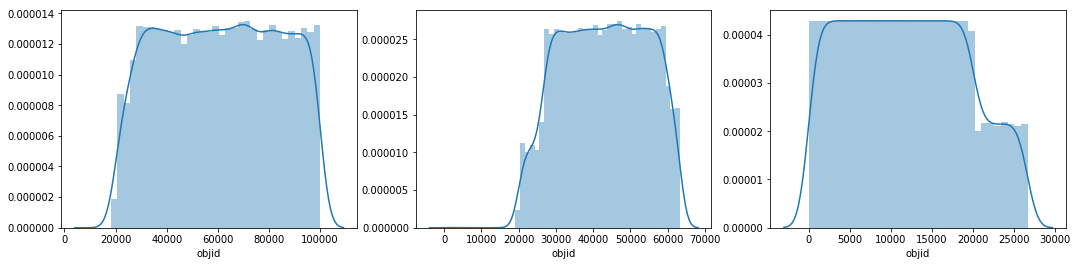

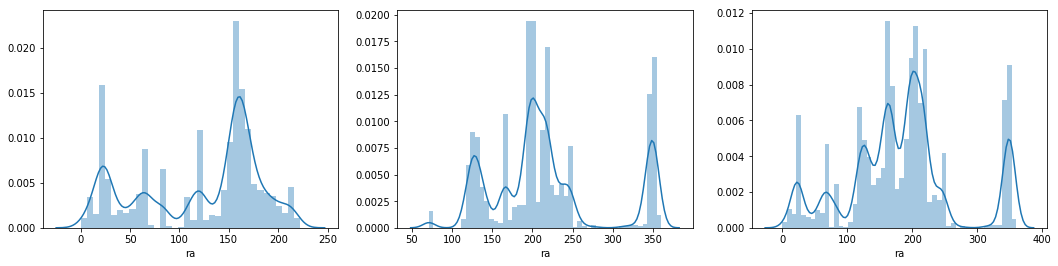

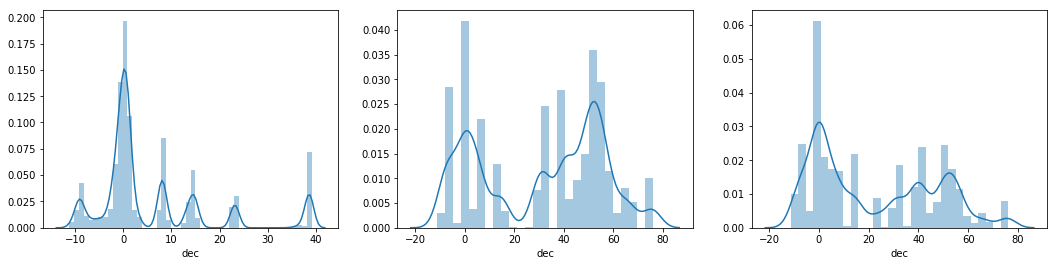

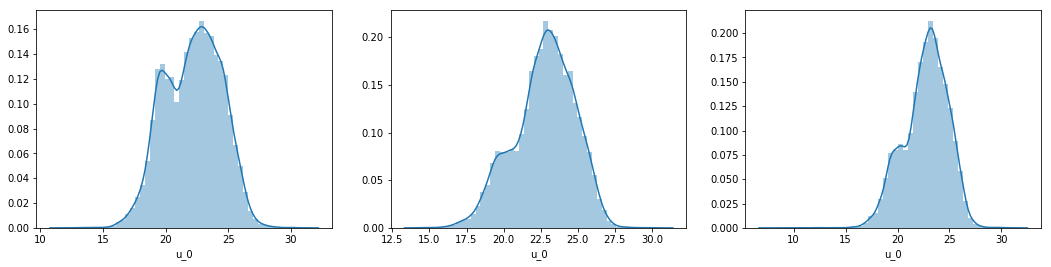

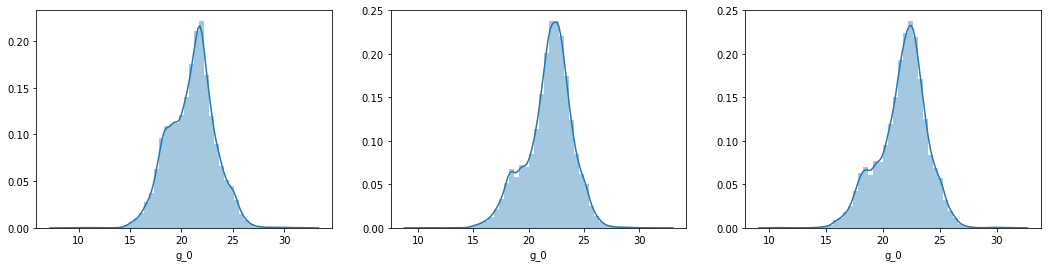

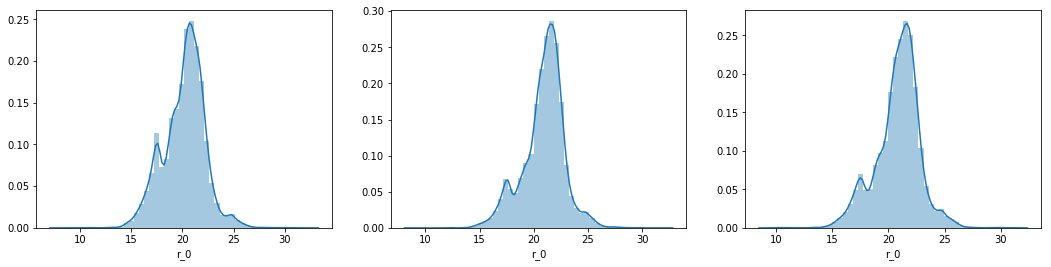

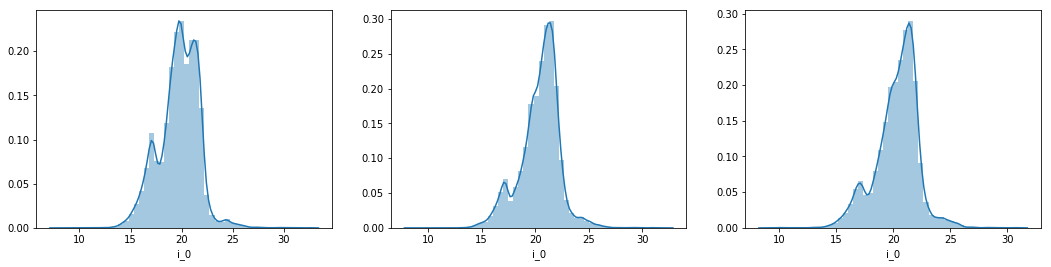

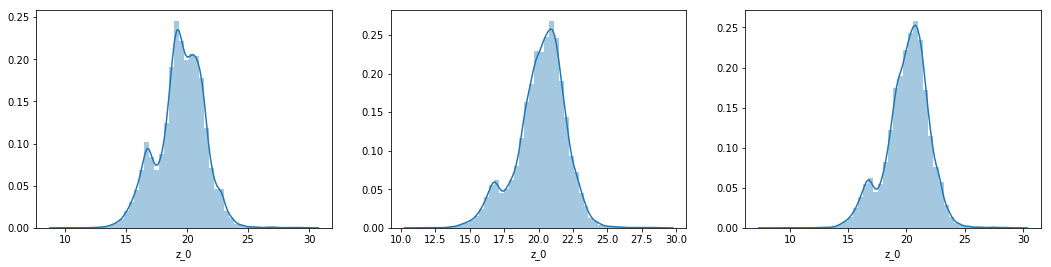

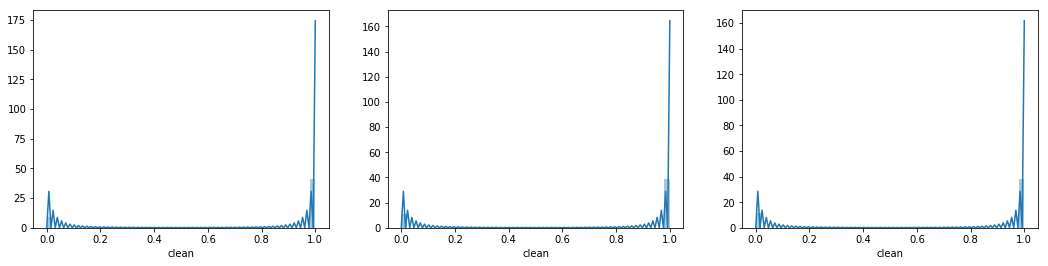

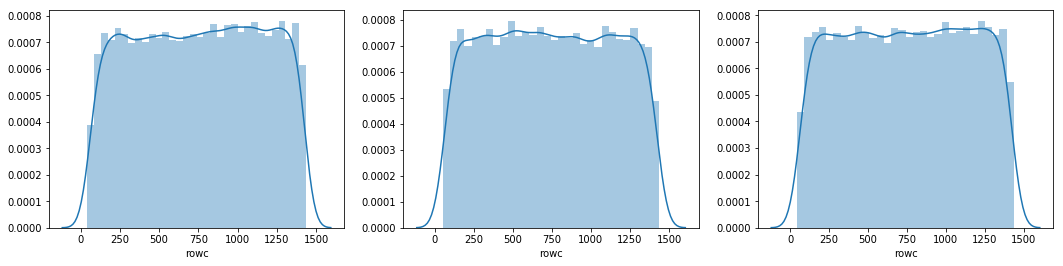

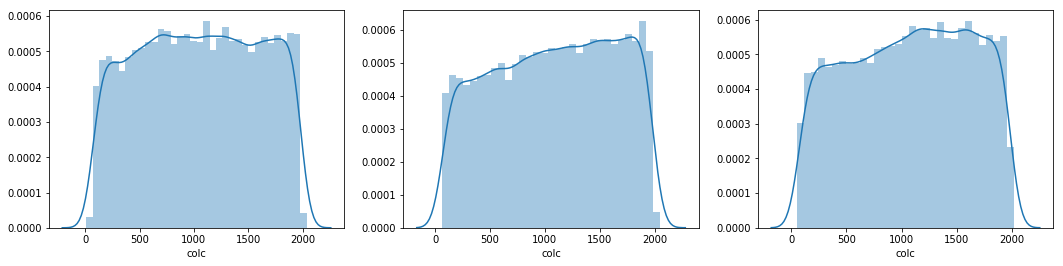

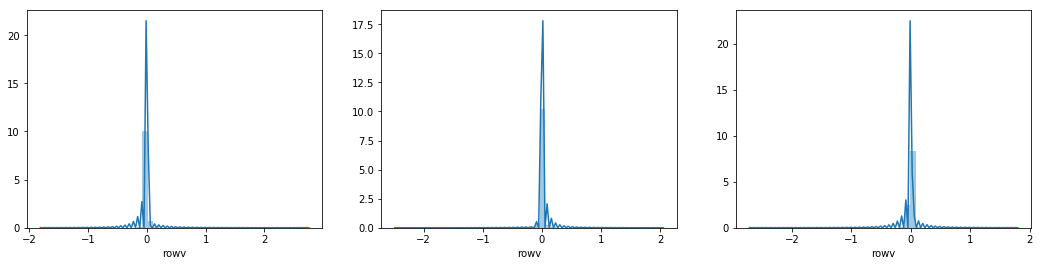

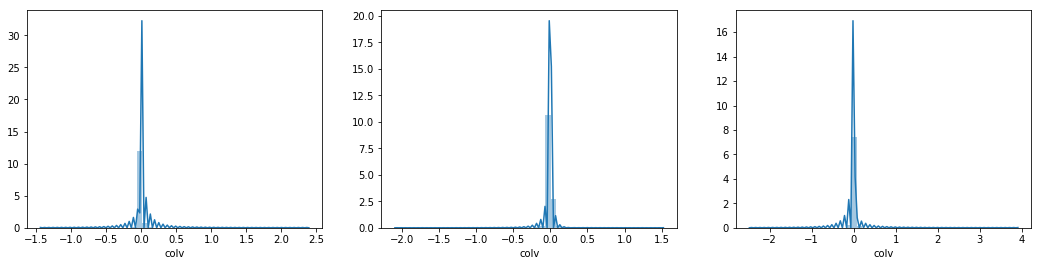

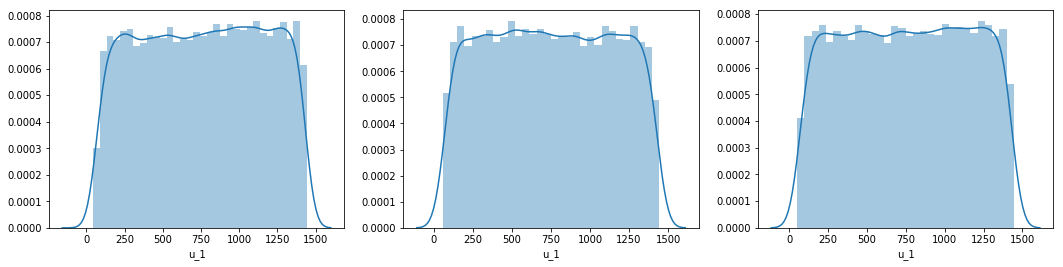

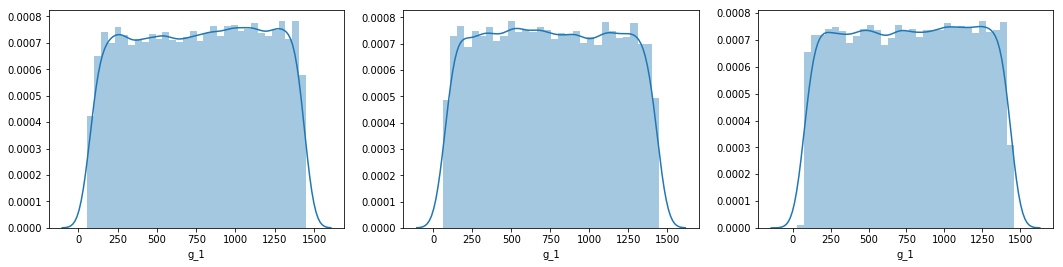

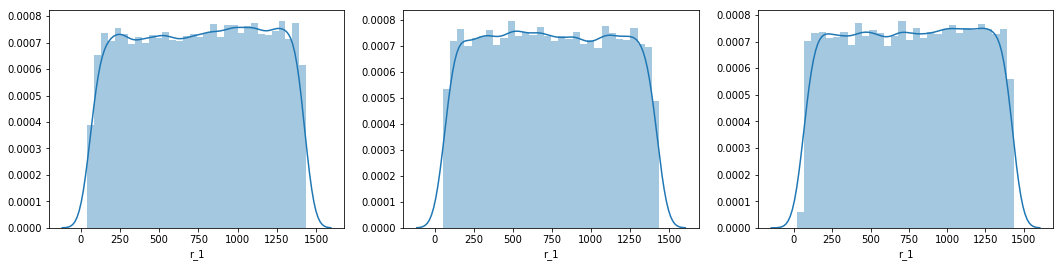

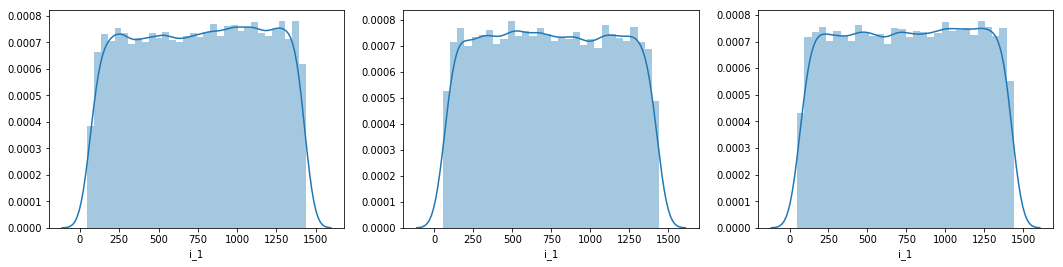

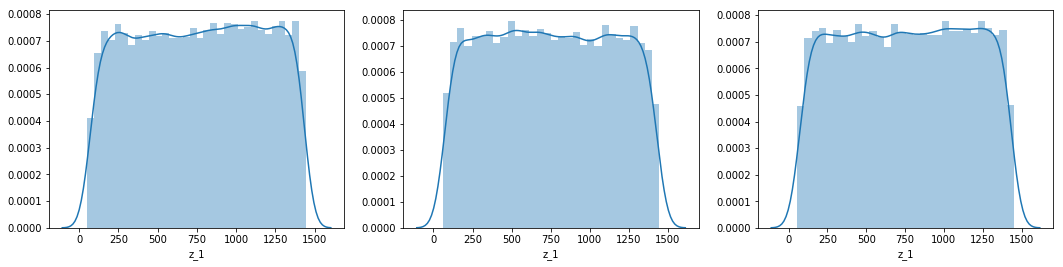

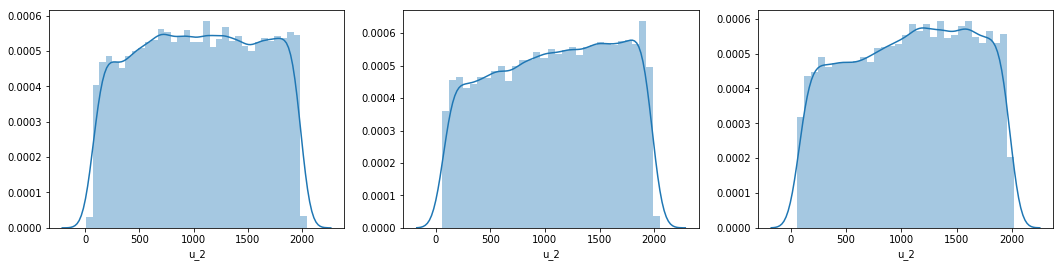

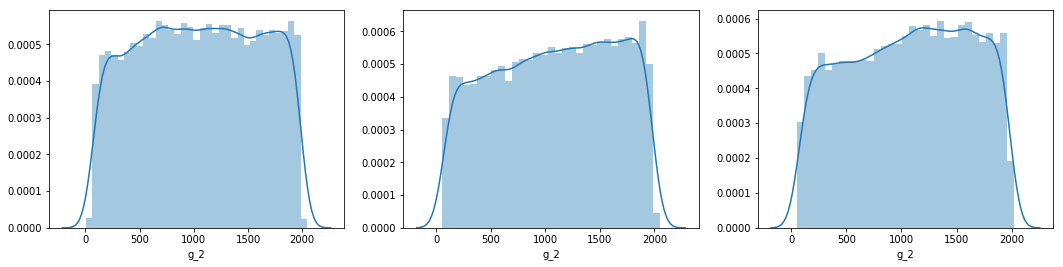

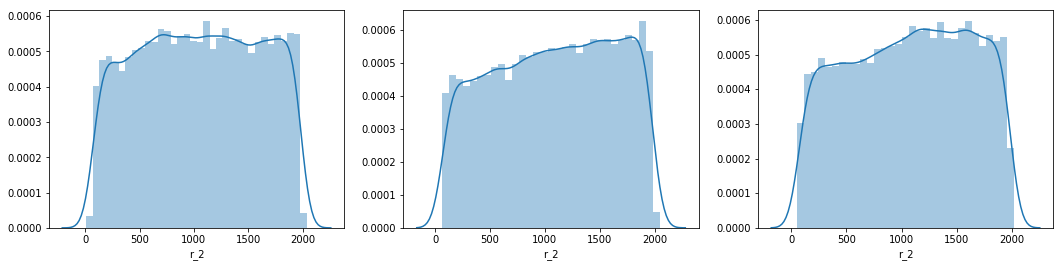

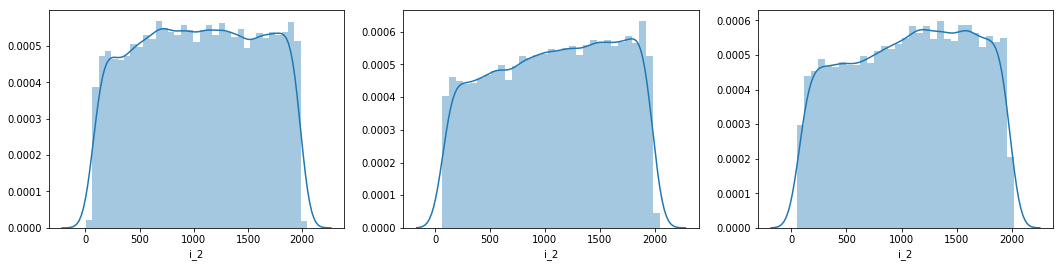

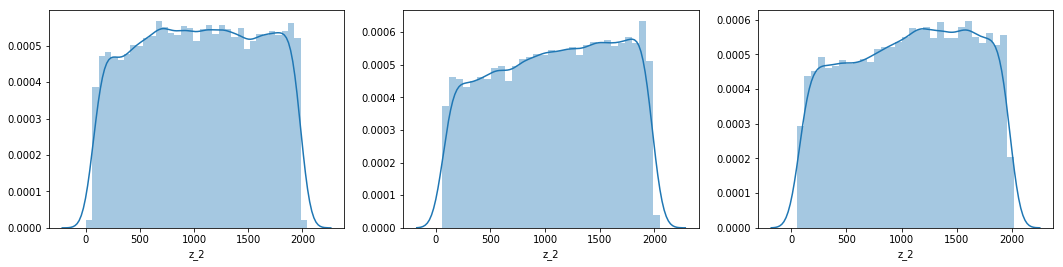

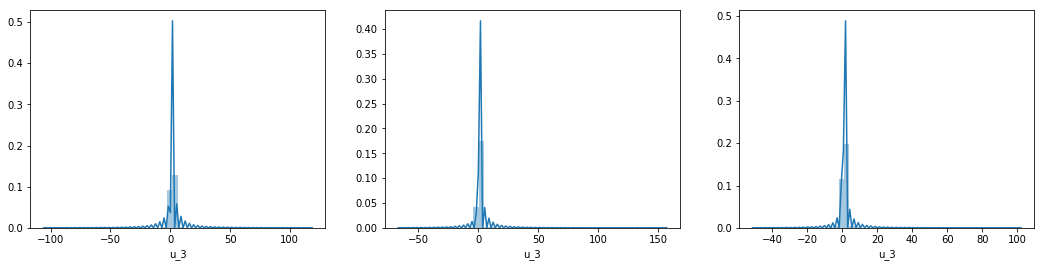

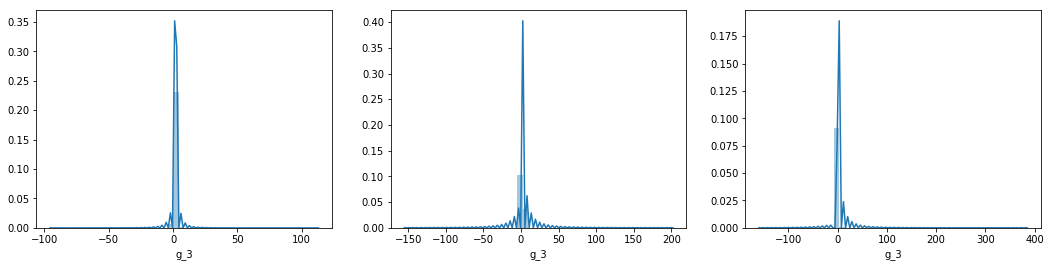

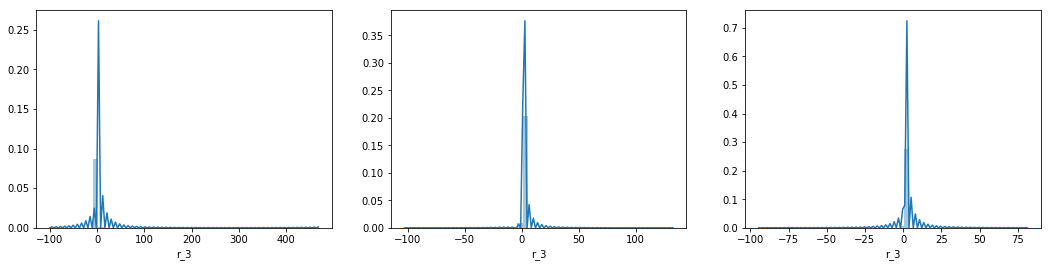

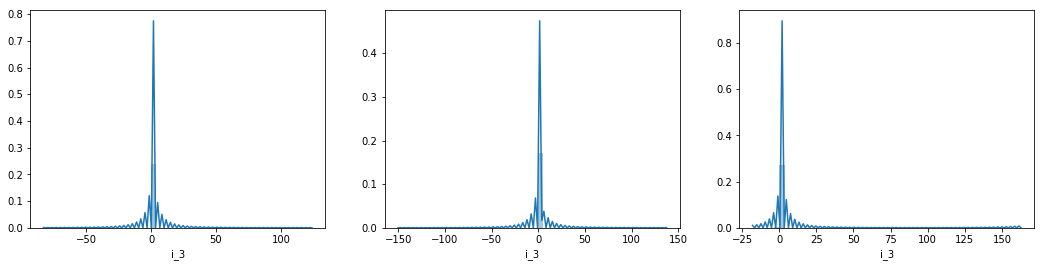

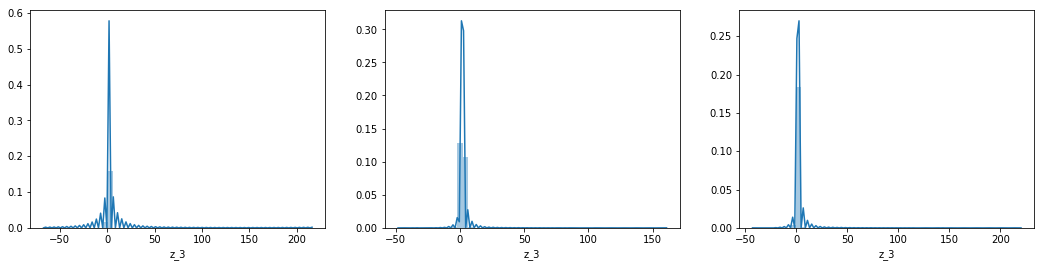

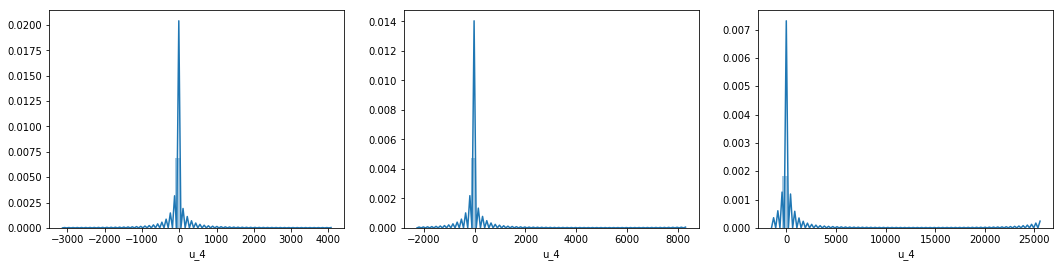

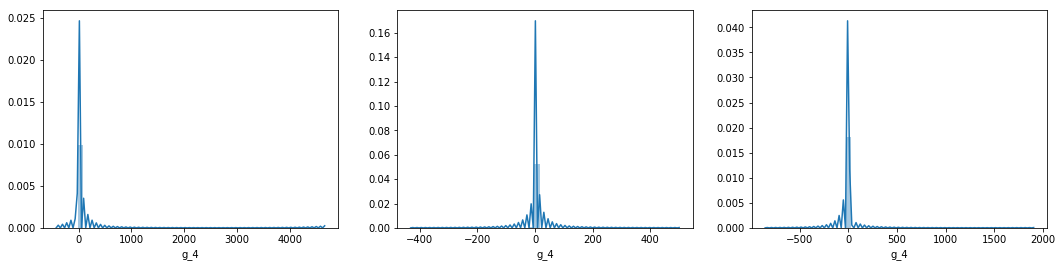

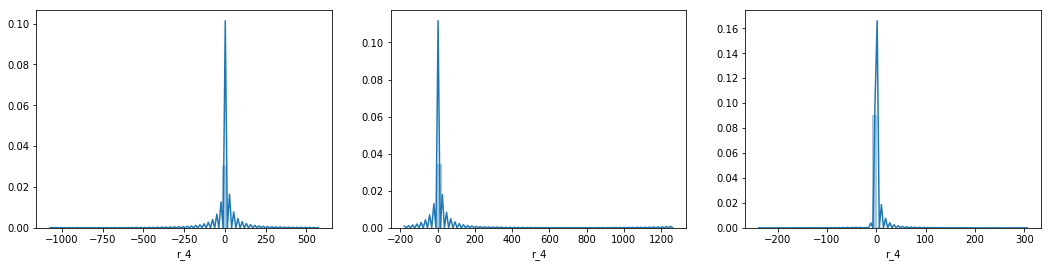

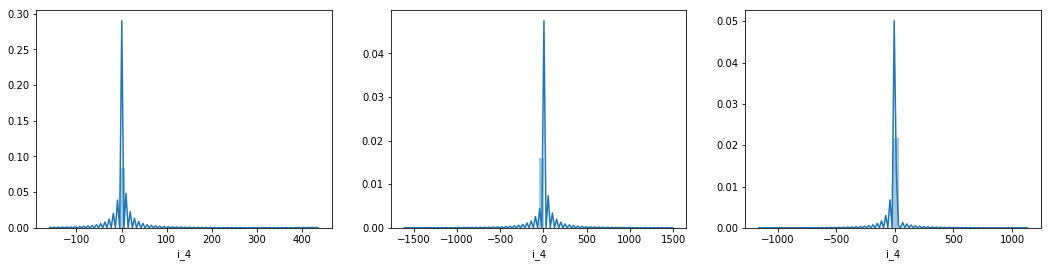

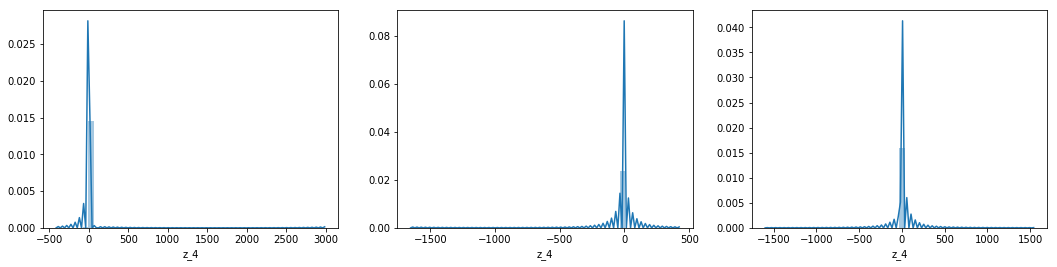

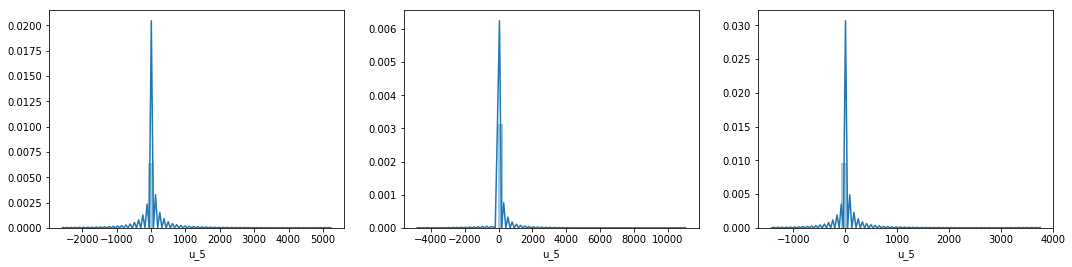

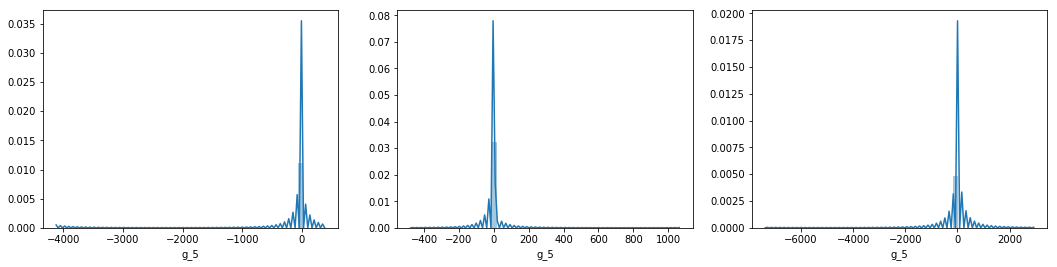

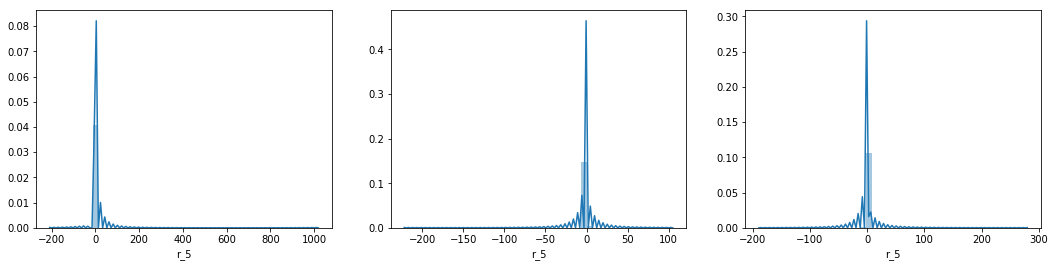

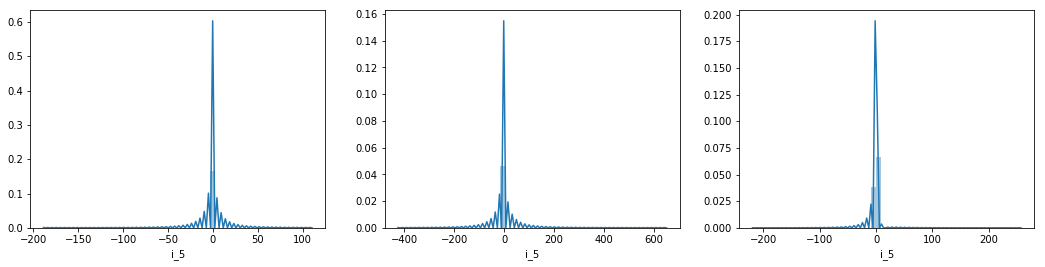

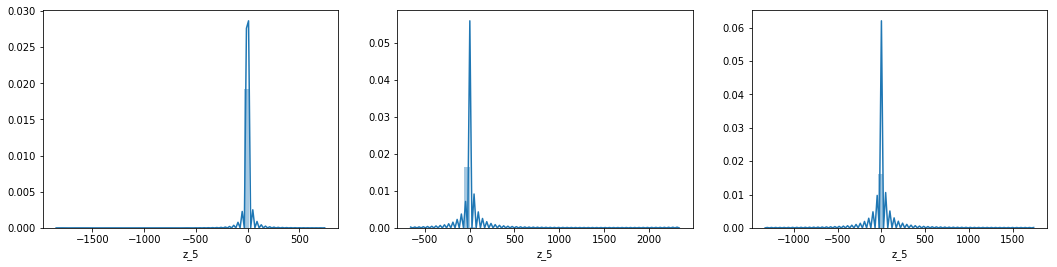

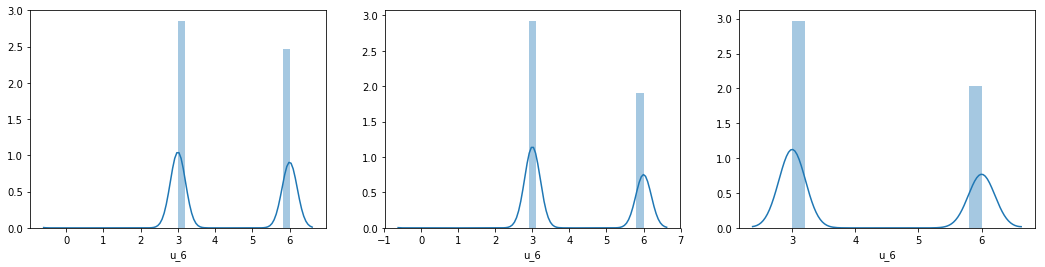

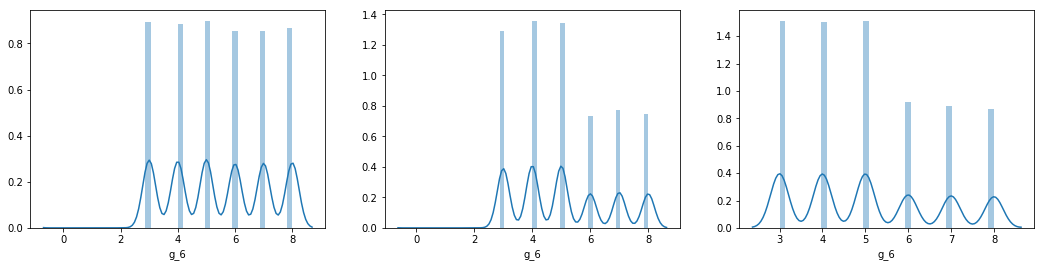

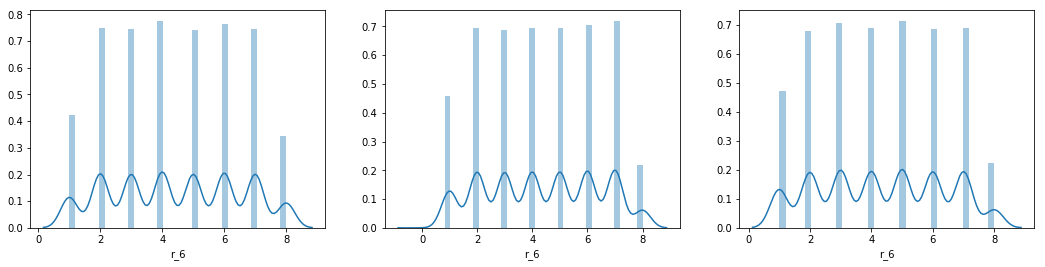

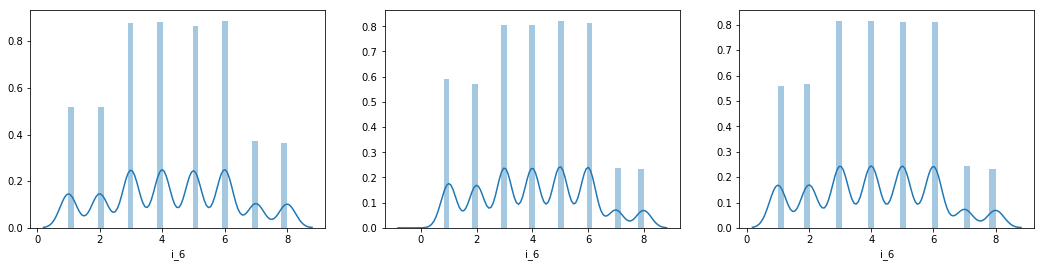

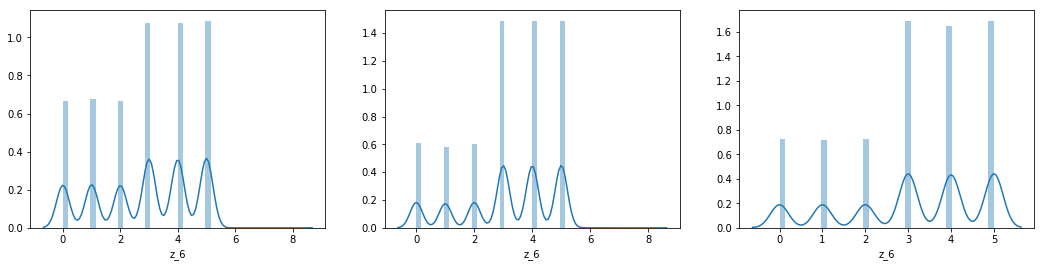

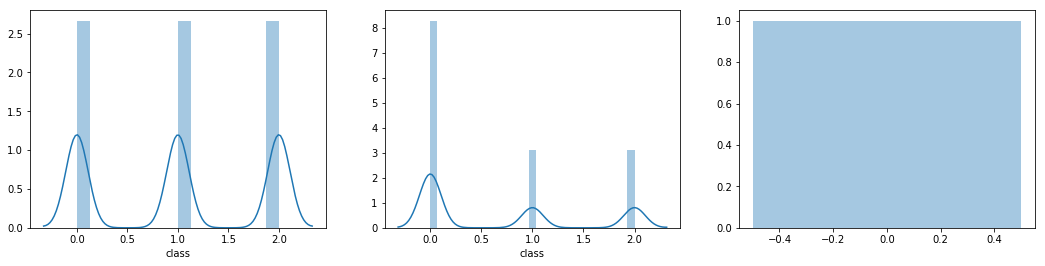

In [8]:
for i, col in enumerate(train_df.columns):
    fig = plt.figure(i, figsize=(18, 4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    sns.distplot(train_df[col].dropna(), ax=ax1)
    sns.distplot(val_df[col].dropna(), ax=ax2)
    try:
        tmp = unlabeled_df[col].dropna()
    except KeyError:
        tmp = np.array([0])
    sns.distplot(tmp, ax=ax3)

visualize distribution between the sets

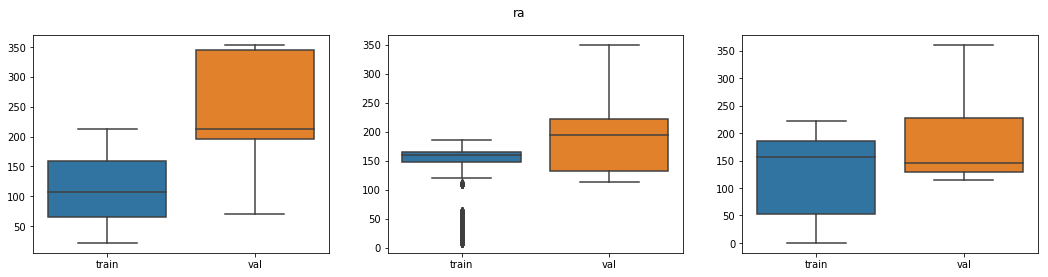

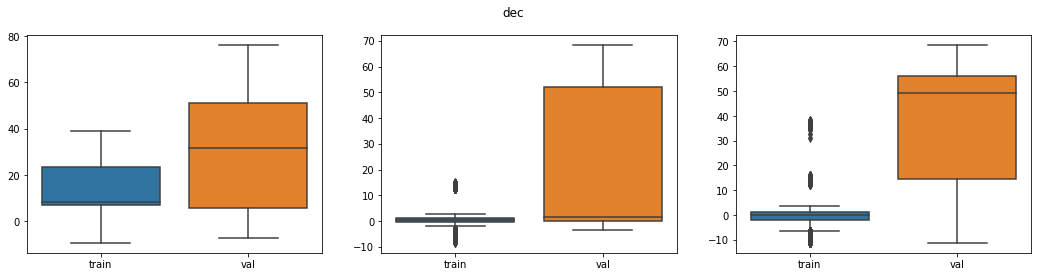

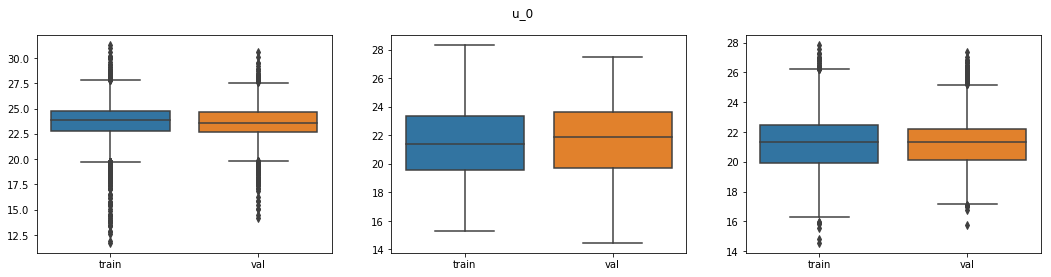

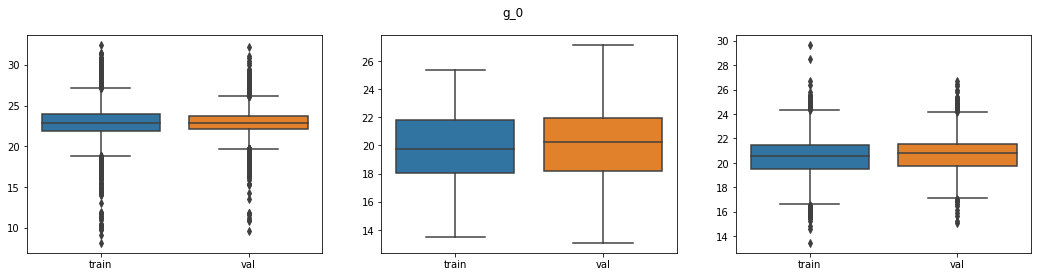

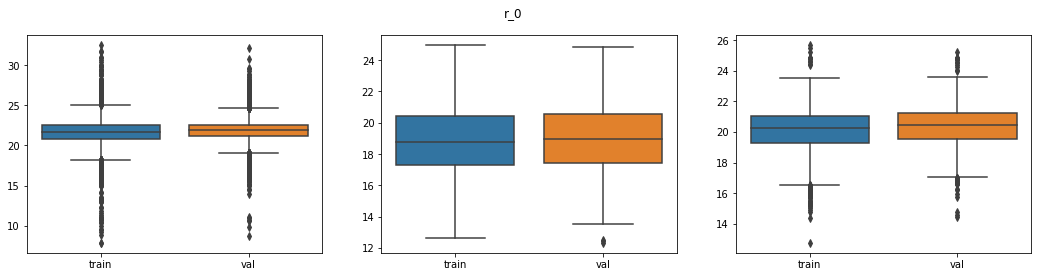

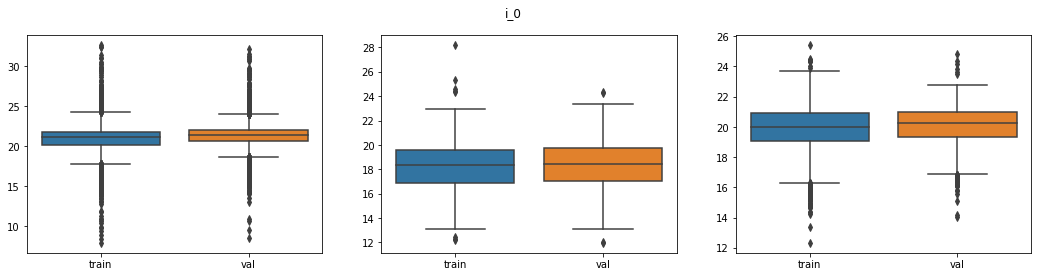

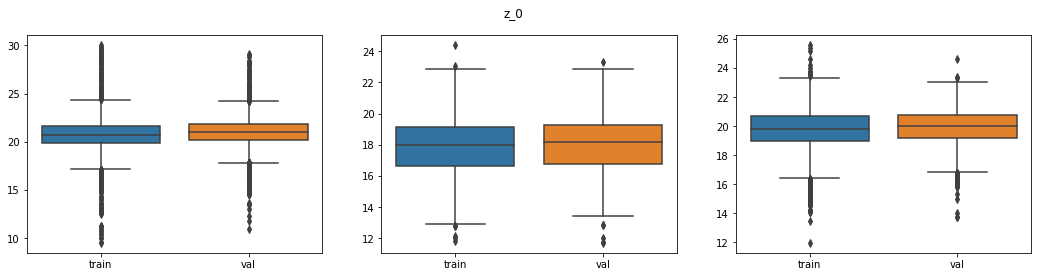

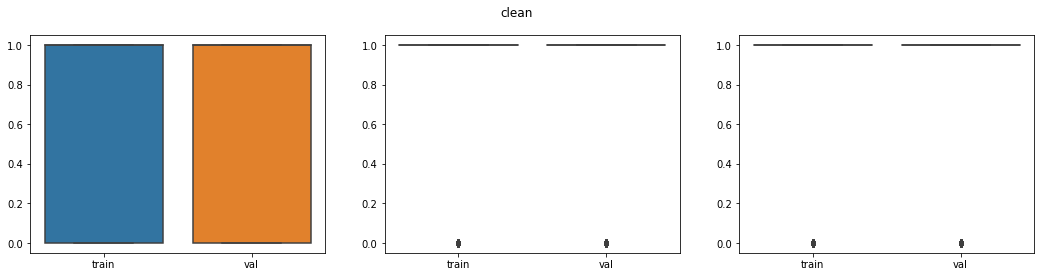

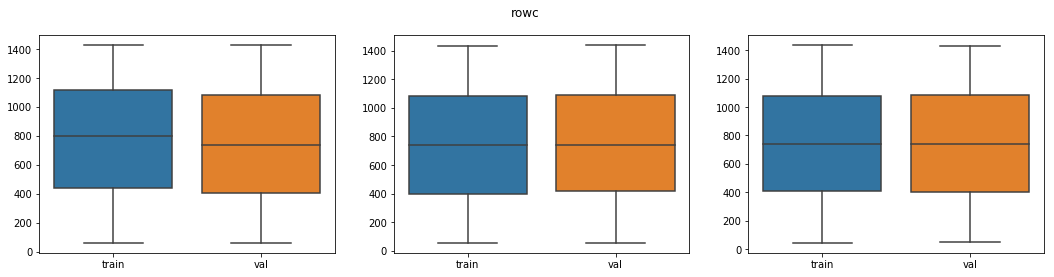

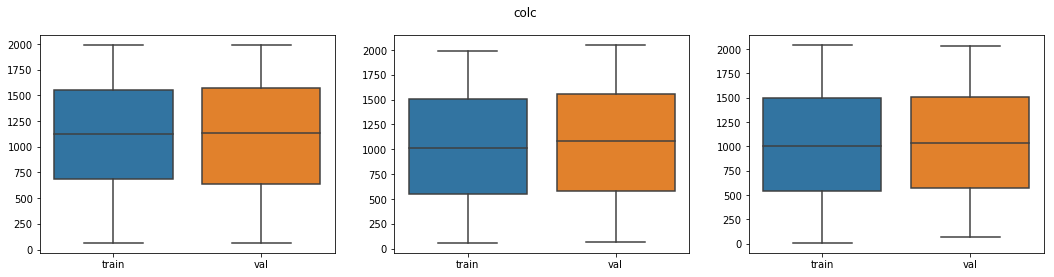

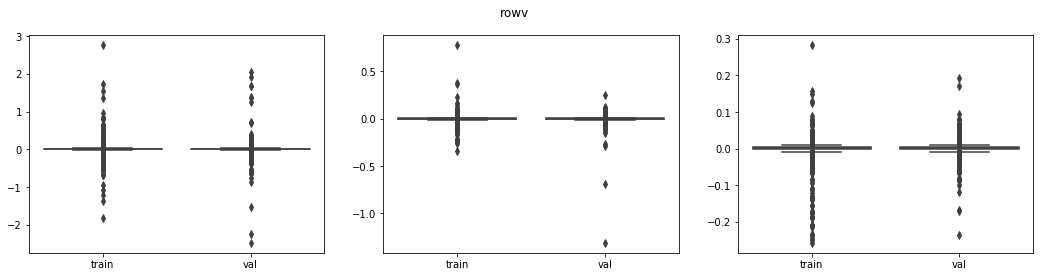

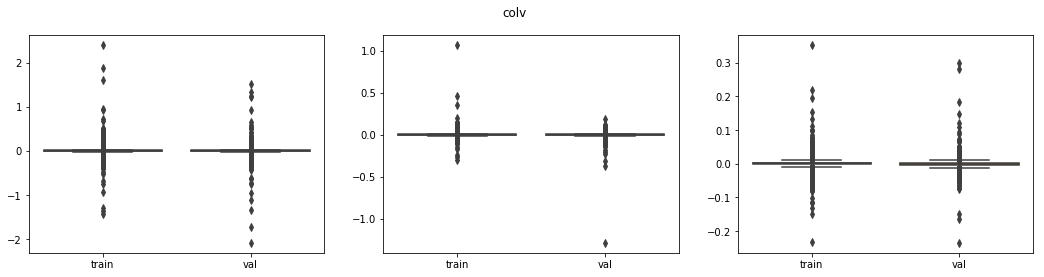

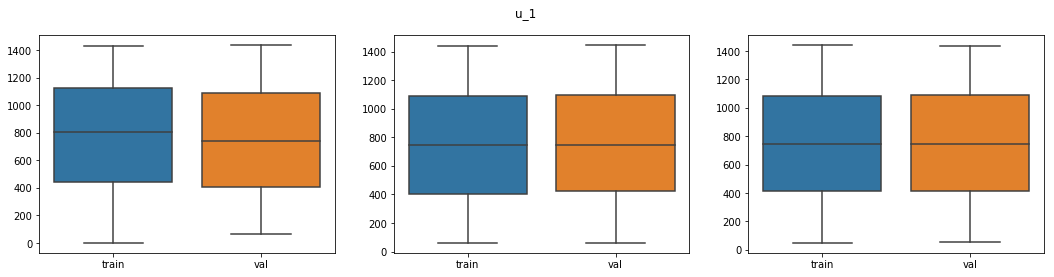

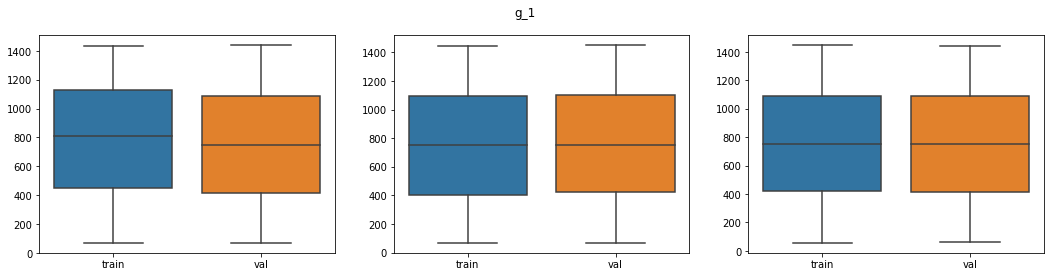

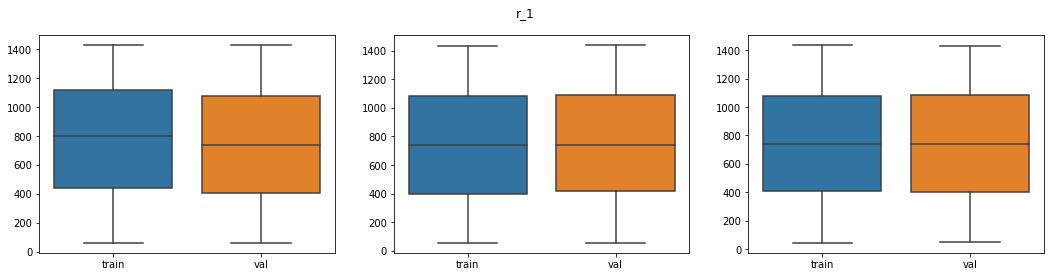

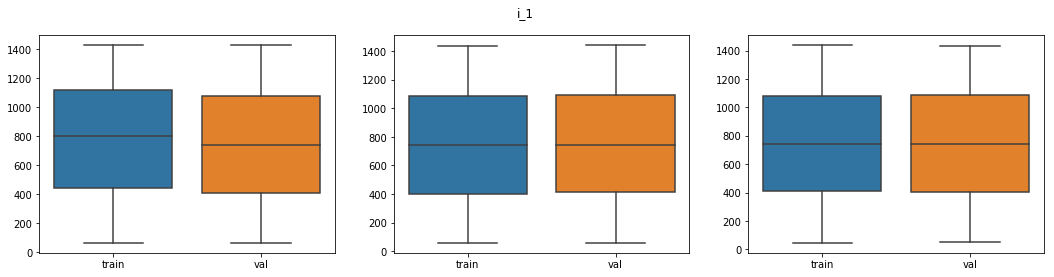

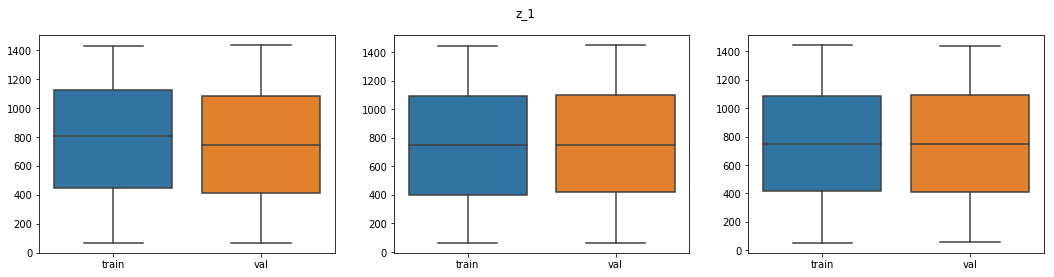

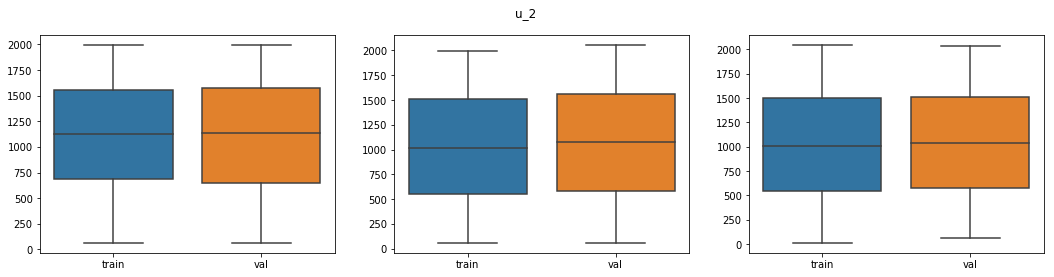

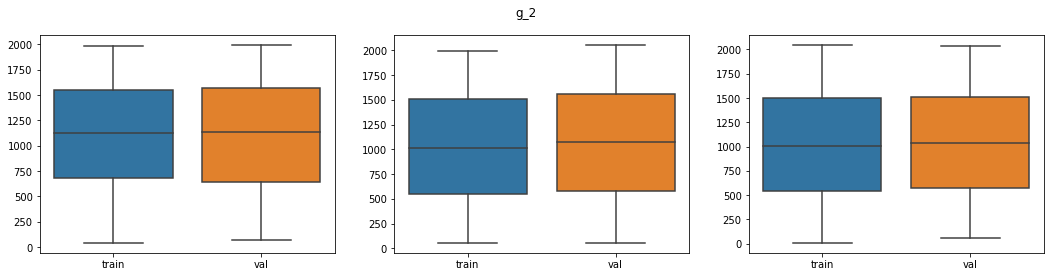

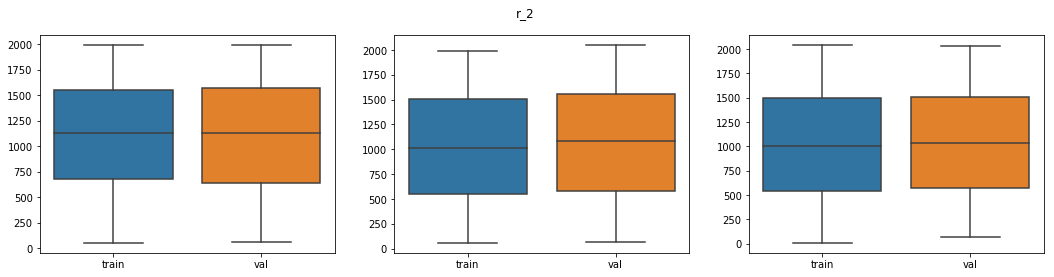

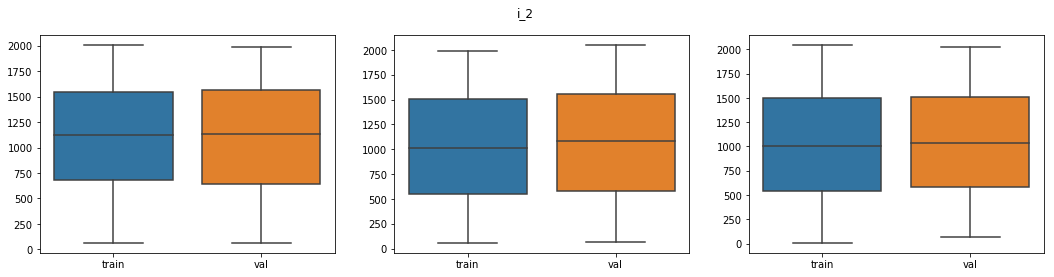

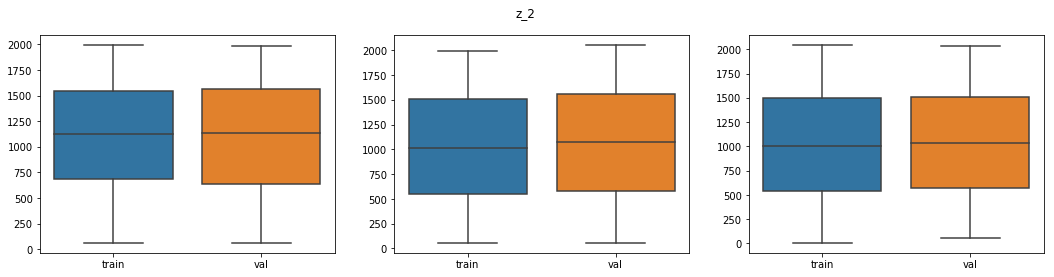

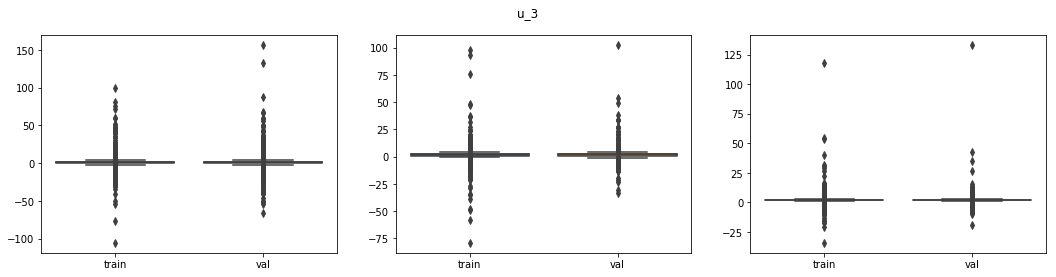

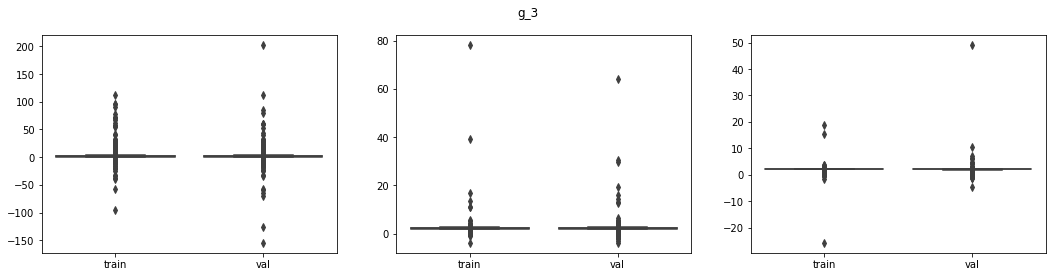

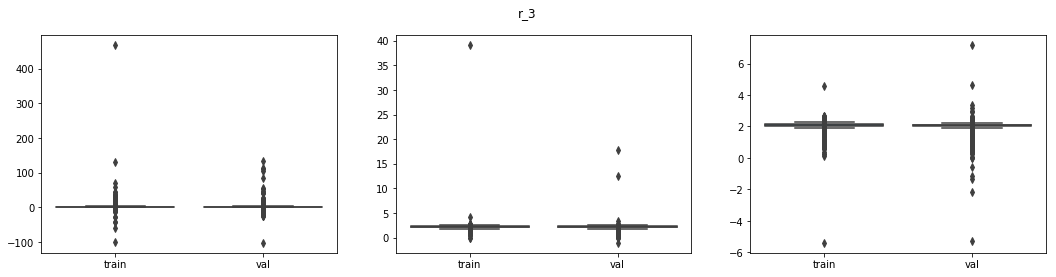

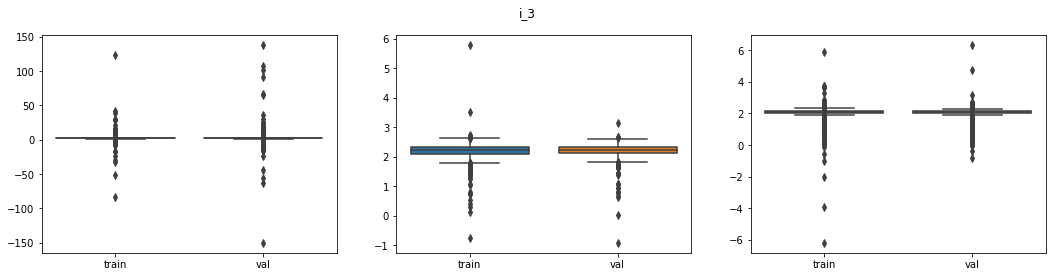

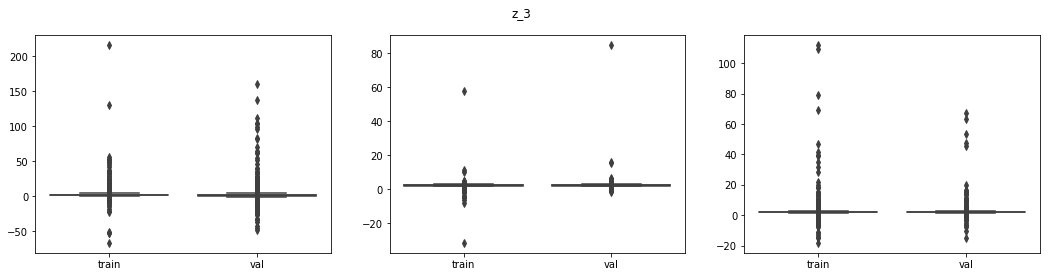

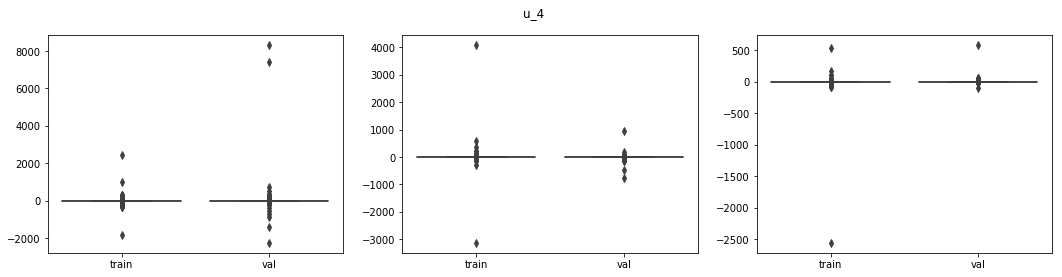

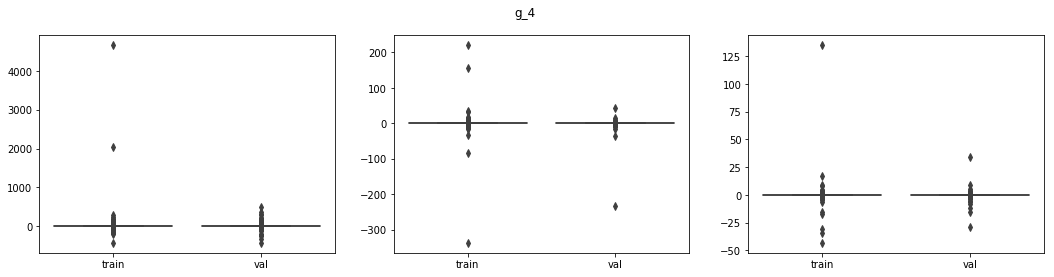

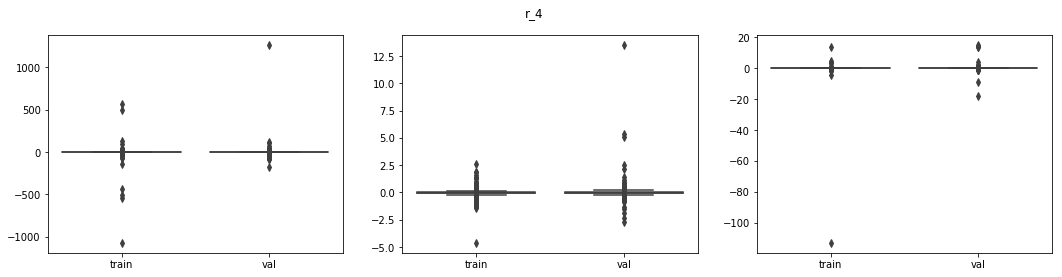

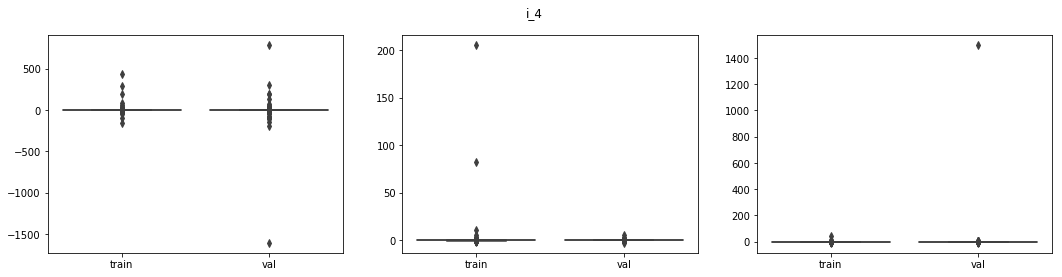

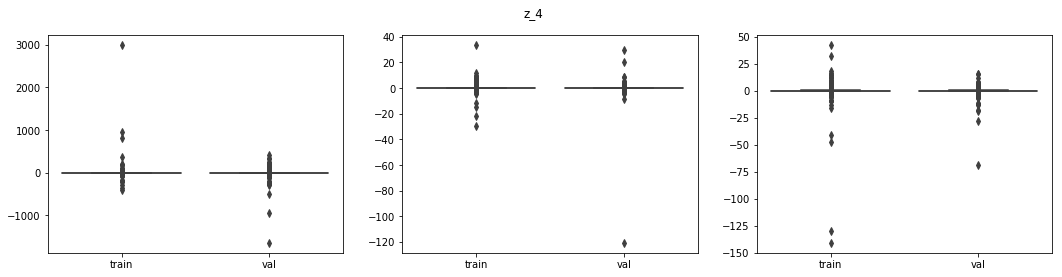

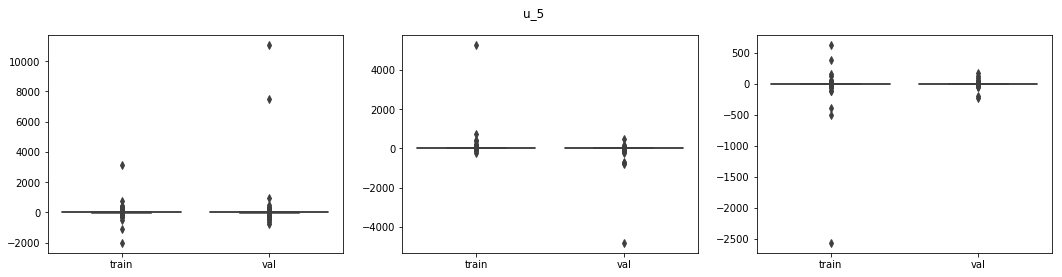

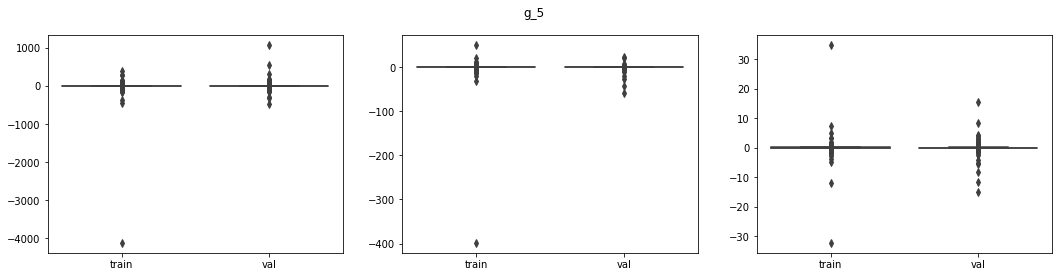

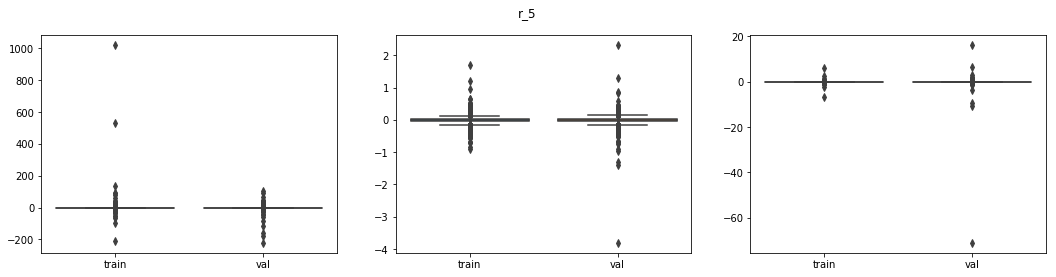

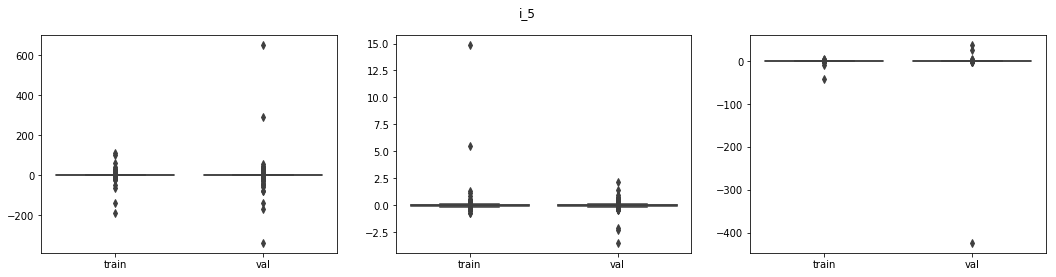

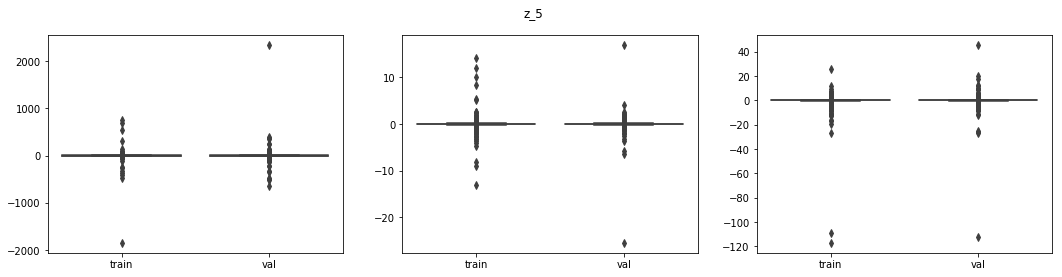

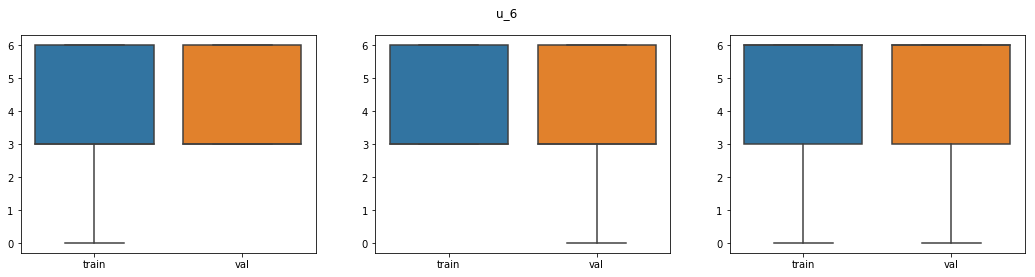

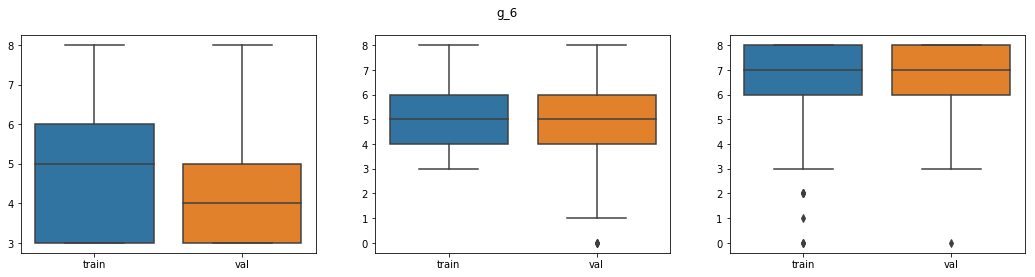

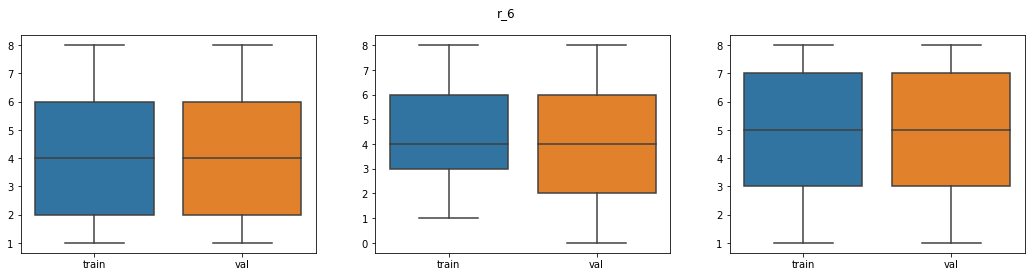

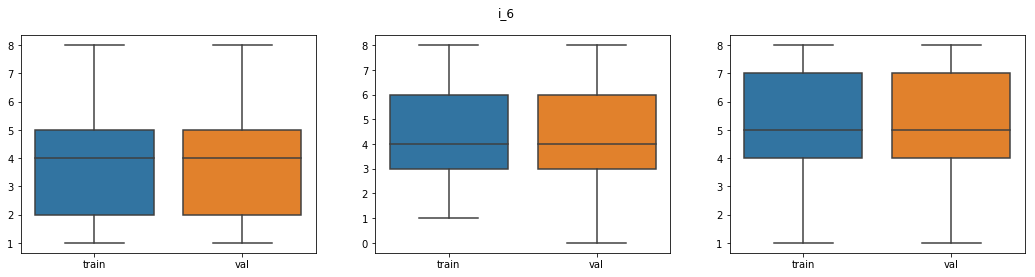

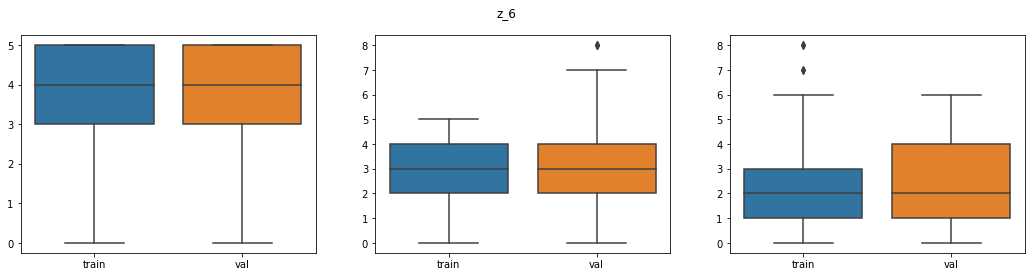

In [27]:
for i, col in enumerate(train_df.columns[1:-1]):
    fig = plt.figure(i, figsize=(18, 4))
    fig.suptitle(col)
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    class_1 = pd.DataFrame({
        'train': train_df[train_df['class'] == 0][col].dropna(),
        'val': val_df[val_df['class'] == 0][col].dropna()
    })
    class_2 = pd.DataFrame({
        'train': train_df[train_df['class'] == 1][col].dropna(),
        'val': val_df[val_df['class'] == 1][col].dropna()
    })
    class_3 = pd.DataFrame({
        'train': train_df[train_df['class'] == 2][col].dropna(),
        'val': val_df[val_df['class'] == 2][col].dropna()
    })
    
    sns.boxplot(data=class_1, ax=ax1)
    sns.boxplot(data=class_2, ax=ax2)
    sns.boxplot(data=class_3, ax=ax3)

we can see that `ra` and `dec` values have different distribution between the sets

 because features has normal or unifoirm distribution fill nan with median for real and mode for categorical

In [342]:
cols = train_df.select_dtypes(include=['float64', 'float32']).columns
train_df[cols] = train_df[cols].fillna(train_df[cols].median())
val_df[cols] = val_df[cols].fillna(val_df[cols].median())
unlabeled_df[cols] = unlabeled_df[cols].fillna(unlabeled_df[cols].median())

cols = train_df.select_dtypes(include=['int64']).columns
train_df[cols] = train_df[cols].fillna(train_df[cols].mode())
val_df[cols] = val_df[cols].fillna(val_df[cols].mode())

cols = unlabeled_df.select_dtypes(include=['int64']).columns
unlabeled_df[cols] = unlabeled_df[cols].fillna(unlabeled_df[cols].mode())

visualize correlation

In [10]:
def plot_corr_matrix(df):
    f, ax = plt.subplots(figsize=(25, 22))
    sns.heatmap(df.corr(), ax=ax);

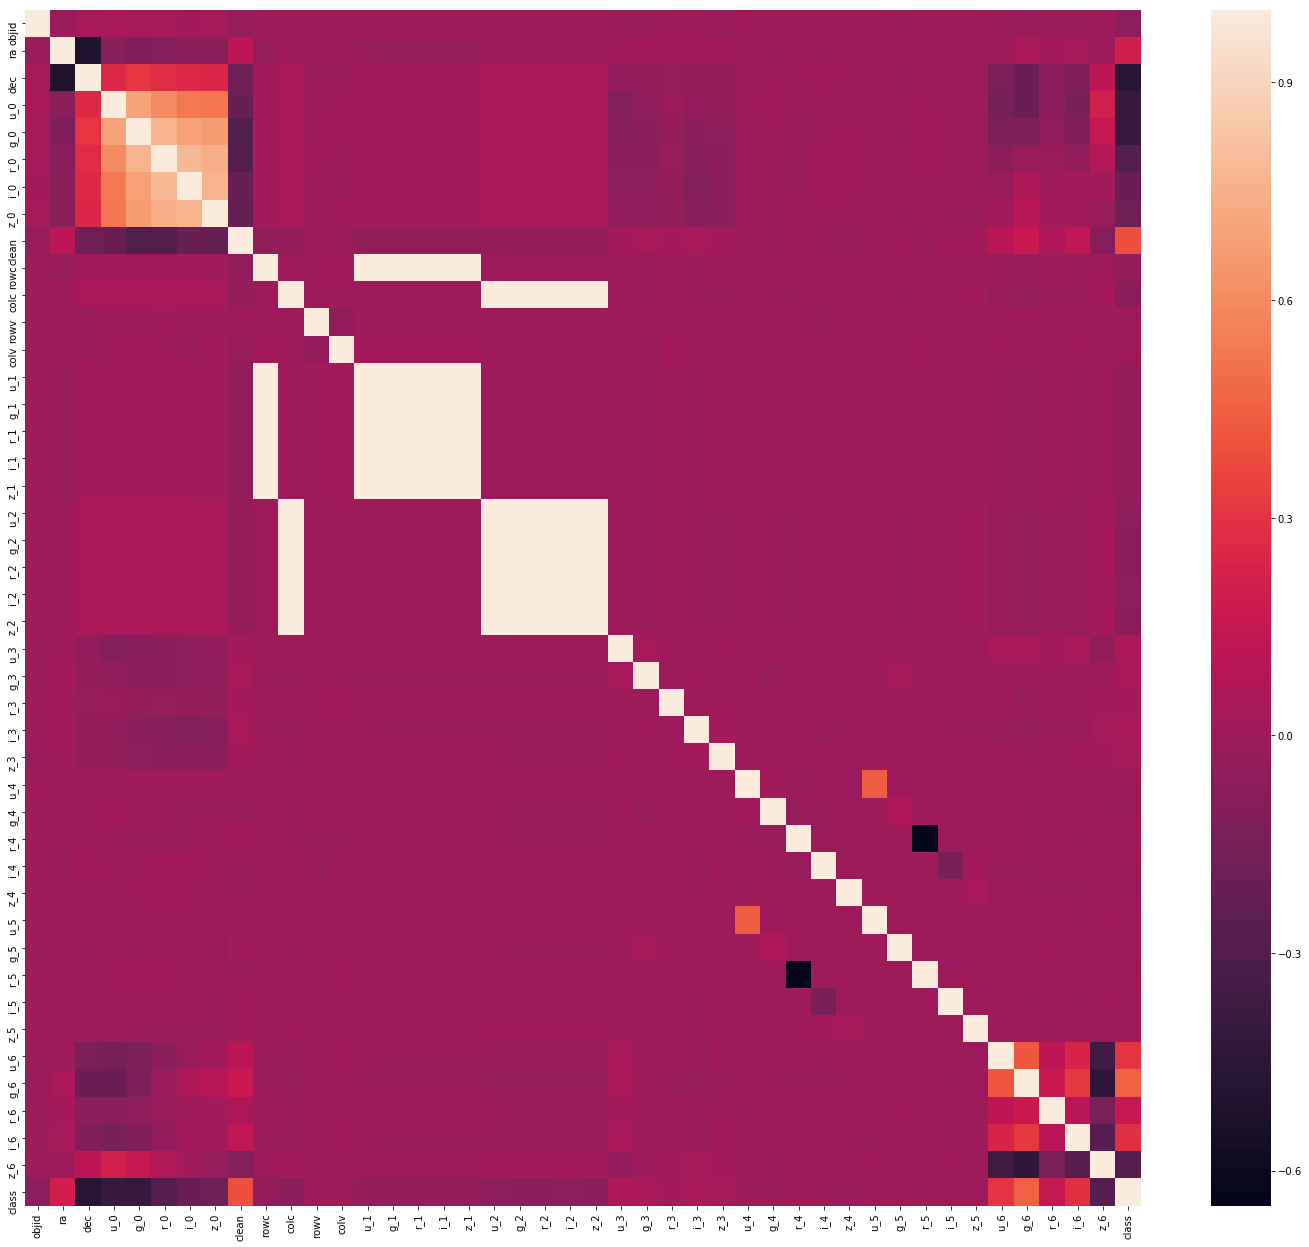

In [11]:
plot_corr_matrix(train_df)

According to correlation matrix above there multicollinearity in the data. It could be a reason of unstable of our model. Need to try to resolve this.

let's make simle beseline

In [343]:
train_y = train_df['class']
train_df.drop(['class', 'objid'], axis=1, inplace=True)

val_y = val_df['class']
val_df.drop(['class', 'objid'], axis=1, inplace=True)


unlabeled_df.drop(['objid'], axis=1, inplace=True)

In [457]:
lr_base = LogisticRegression()
lr_base.fit(train_df, train_y)

val_pred = lr_base.predict(val_df)

print(f'Simple baseline: {f1_score(val_y, val_pred, average="macro")}')

Simple baseline: 0.47073624704493344


let's try something more interestin

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
forest = RandomForestClassifier(n_estimators=150, random_state=42)

In [40]:
forest.fit(train_df, train_y)
pred = forest.predict(val_df)

print(f'resutl: {f1_score(val_y, pred, average="macro"):.03f}')

resutl: 0.490


and Random forest give us 2%

look at features importance

(-1, 42)

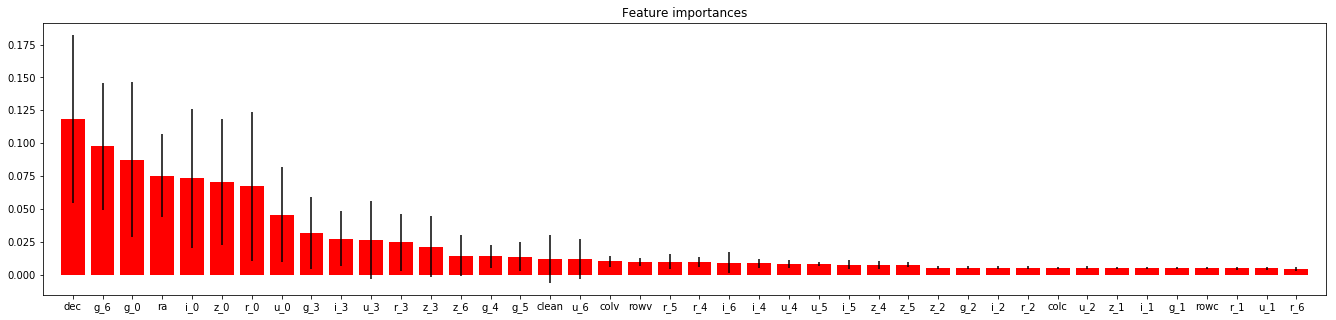

In [56]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(23, 5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), train_X_train.columns.values[indices])
plt.xlim([-1, X_train.shape[1]])

at graphs above we can see thar `dec` and `ra` have hight importance, but thay have shift. let's drop them

In [344]:
columns_to_rm = ['dec', 'ra']
train_df_rm = train_df.drop(columns_to_rm, axis=1)
val_df_rm = val_df.drop(columns_to_rm, axis=1)
unlabeled_df_rm = unlabeled_df.drop(columns_to_rm, axis=1)

In [58]:
forest.fit(train_df_rm, train_y)
pred = forest.predict(val_df_rm)

print(f'resutl: {f1_score(val_y, pred, average="macro"):.03f}')

resutl: 0.828


This gives us a good increase in accuracy.

(-1, 40)

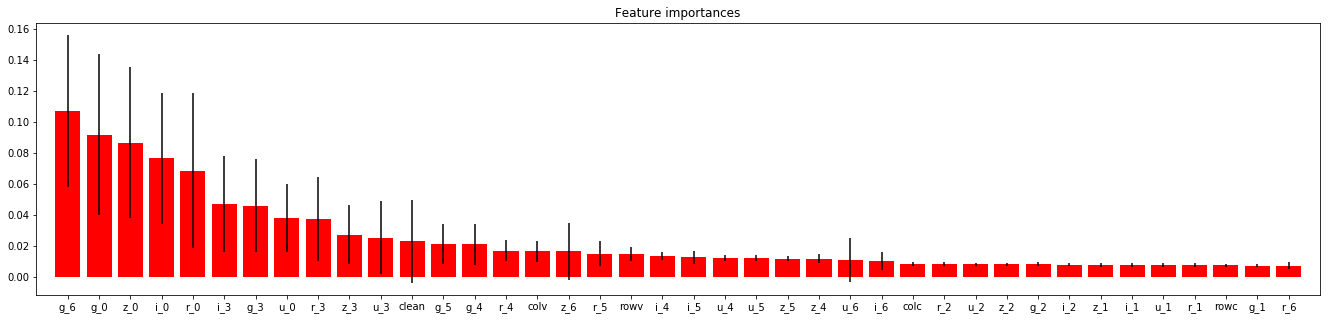

In [59]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(23, 5))
plt.title("Feature importances")
plt.bar(range(train_df_rm.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_df_rm.shape[1]), train_df_rm.columns.values[indices])
plt.xlim([-1, train_df_rm.shape[1]])

let's try grid search to optimize RandomForest

In [332]:
%%time
n_estimators = [100, 150, 200, 300]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split) #, 
             #min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(train_df_rm, train_y)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 27.5min finished


CPU times: user 56.8 s, sys: 1.69 s, total: 58.5 s
Wall time: 28min 24s


In [333]:
bestF.best_params_

{'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 300}

In [334]:

pred = bestF.predict(val_df_rm)

print(f'resutl: {f1_score(val_y, pred, average="macro"):.03f}')

resutl: 0.825


Grid search did'n give any impact

try to reduce using PCA, because multicollinearity

In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

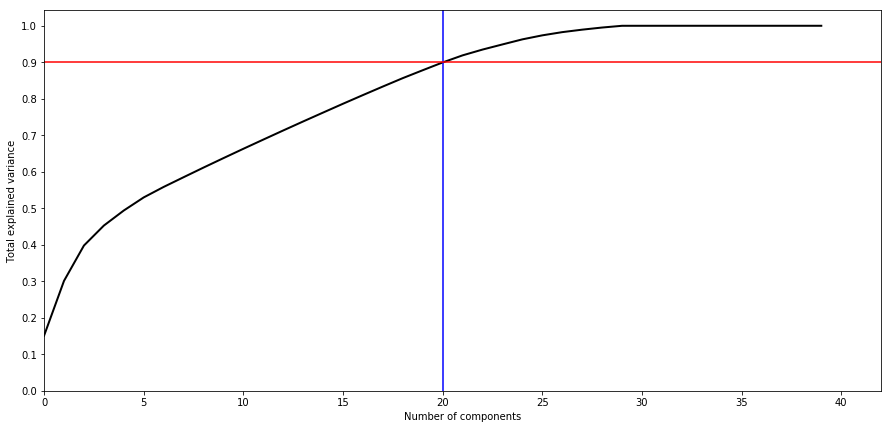

In [66]:
scaler = StandardScaler().fit(train_df_rm)
X_train_scaled = scaler.transform(train_df_rm)

pca = PCA().fit(StandardScaler().fit_transform(X_train_scaled))

plt.figure(figsize=(15,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 42)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(20, c='b')
plt.axhline(0.9, c='r')

Usually leave around 90% of initial dats set's variance using PCA decomposition. So optimal number of features is 22

In [67]:
pca_features_n = 20

In [68]:
pca = PCA(n_components=pca_features_n)
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [70]:
X_train_reduced = pca.transform(X_train_scaled)
X_test_reduced = pca.transform(scaler.transform(val_df_rm))

In [73]:
%%time
forest.fit(X_train_reduced, train_y)

CPU times: user 19.8 s, sys: 85.2 ms, total: 19.8 s
Wall time: 19.9 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [74]:
pred = forest.predict(X_test_reduced)

print(f'our baseline: {f1_score(val_y, pred, average="macro"):.03f}')

our baseline: 0.781


After PCA reducing we have result 0.781% f1 score it is almost on 4% lower than our the best score. 

We have a lot of data. So time to use Neural Networks. Let's build a not deep network on Keras

In [154]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import keras.backend as K

In [269]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


In [430]:
earlyStopping = EarlyStopping(monitor='val_f1', patience=15, verbose=1, mode='max')
mcp_save = ModelCheckpoint('model_base.h5', save_best_only=True, monitor='val_f1', mode='max', verbose=1)

In [458]:
model = Sequential()

model.add(Dense(units=100, input_dim=train_df_rm.shape[1], activation='tanh'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.5))

model.add(Dense(units=100, activation='tanh'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.5))

model.add(Dense(units=100, activation='tanh'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.5))

model.add(Dense(units=100, activation='tanh'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[f1])

In [459]:
scaler = StandardScaler().fit(train_df_rm)
X_scale = scaler.transform(train_df_rm)

In [460]:
val_X_train, val_X_test, val_y_train, val_y_test = train_test_split(
    val_df_rm, val_y.as_matrix(), test_size=0.2, random_state=17)

In [461]:
history = model.fit(X_scale, to_categorical(train_y), 
                    validation_data=(scaler.transform(val_X_test), to_categorical(val_y_test)), 
                    batch_size=128, epochs=150, 
                    verbose=True, callbacks=[earlyStopping, mcp_save], class_weight=[1, 2, 2])

Train on 30000 samples, validate on 4667 samples
Epoch 1/150
30000/30000 [==============================] - 7s 228us/step - loss: 0.9844 - f1: 0.5941 - val_loss: 0.5900 - val_f1: 0.7607

Epoch 00001: val_f1 improved from 0.29061 to 0.76067, saving model to model_base.h5
Epoch 2/150
30000/30000 [==============================] - 3s 88us/step - loss: 0.7247 - f1: 0.7005 - val_loss: 0.5349 - val_f1: 0.7667

Epoch 00002: val_f1 improved from 0.76067 to 0.76667, saving model to model_base.h5
Epoch 3/150
30000/30000 [==============================] - 3s 86us/step - loss: 0.6767 - f1: 0.7311 - val_loss: 0.5280 - val_f1: 0.7691

Epoch 00003: val_f1 improved from 0.76667 to 0.76913, saving model to model_base.h5
Epoch 4/150
30000/30000 [==============================] - 2s 81us/step - loss: 0.6578 - f1: 0.7407 - val_loss: 0.5202 - val_f1: 0.7778

Epoch 00004: val_f1 improved from 0.76913 to 0.77783, saving model to model_base.h5
Epoch 5/150
30000/30000 [==============================] - 3s 84us

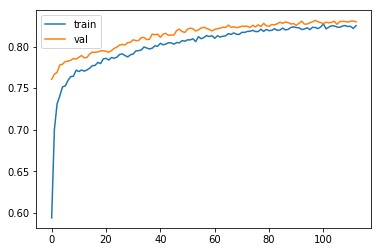

In [462]:
plt.plot(history.history['f1'], label='train')
plt.plot(history.history['val_f1'], label='val')
plt.legend();

In [463]:
model.load_weights('model_base.h5')

In [464]:
pred = model.predict(scaler.transform(val_df_rm))
pred = np.argmax(pred, axis=1)
print(f'nn results: {f1_score(val_y, pred, average="macro"):.03f}')

nn results: 0.836


Currently the NN has the best accyracy

I still don't use unlabeled data. So the neural network can be used with an unlabeled dataset. First, we train the network with all available labeled data. Next, we predict the unlabeled dataset and choose from the prediction items that have confidence more than a threshold(0.9). Next, fine-tune the model with the new subset. And repeat this process iteratively until the model's accuracy stop increasing or we label all unlabeled data. It will be for future improvements.